In [80]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [81]:
# Read in the df_levels

df_levels = pd.read_excel("./pwt100.xlsx", sheet_name = "Data", header = 0)

# Clean the df_levels

#Select the country to analyse
country_selection = "Germany"

# Extract relevant columns
df_levels = df_levels.loc[:, ("country", "year", "rgdpna", "pop", "rnna", "emp", "hc")]

# Calculate GDP per capita and per worker
df_levels["rgdpna_pc"] = df_levels["rgdpna"] / df_levels["pop"]
df_levels["rgdpna_pw"] = df_levels["rgdpna"] / df_levels["emp"]

# Filter for the country of choice
df_levels = df_levels.loc[df_levels["country"] == country_selection,:]
df_levels = df_levels.reset_index(drop = True)

# Remove rows with missing df_levels
ymax = df_levels.loc[df_levels["rgdpna"] > 0, "year"].max()
ymin = df_levels.loc[df_levels["rgdpna"] > 0, "year"].min()
df_levels = df_levels.loc[df_levels["year"] >= ymin, :]


# Extract TFP measure
alpha = 0.3  # benchmark alpha value

rnna = df_levels["rnna"]  # capital variable
emp = df_levels["emp"]  # labour variable
hc = df_levels["hc"]  # human capital variable

# tfp from cobb-douglas production function without human capital
tfp_full = df_levels["rgdpna"] / ((rnna ** alpha) * (emp ** (1 - alpha)))

# tfp from cobb-douglas production function with human capital
tfp_ex_hc = df_levels["rgdpna"] / ((rnna ** alpha) * ((hc * emp) ** (1 - alpha)))

# add new variables to the df_levels frame
df_levels["TFP_full"] = tfp_full
df_levels["TFP_ex_hc"] = tfp_ex_hc

# Check structure of df_levels is what is expected
df_levels.head()

,country,year,rgdpna,pop,rnna,emp,hc,rgdpna_pc,rgdpna_pw,TFP_full,TFP_ex_hc
0,Germany,1950,495205.0000,68.734097,1918304.625,30.855808,2.426997,7204.648339,16049.004319,585.293768,314.648314
1,Germany,1951,543256.9375,69.073867,2051990.875,31.436510,2.469304,7864.869267,17281.082920,621.081545,329.872736
2,Germany,1952,593964.5000,69.448821,2209629.750,32.024281,2.512348,8552.549804,18547.317530,655.585092,344.011682
3,Germany,1953,646873.8125,69.846895,2367170.500,32.835850,2.556143,9261.310953,19700.230607,687.237621,356.284819
4,Germany,1954,697127.4375,70.264068,2552261.250,33.835823,2.587326,9921.535351,20603.235697,709.040294,364.481199


In [82]:
#Extract TFP measure

In [83]:
year_of_interest = {
    'Germany': 1989,
    'Indonesia' : 1997
}

In [84]:
import reg_functions as reg

NameError: name 'np' is not defined

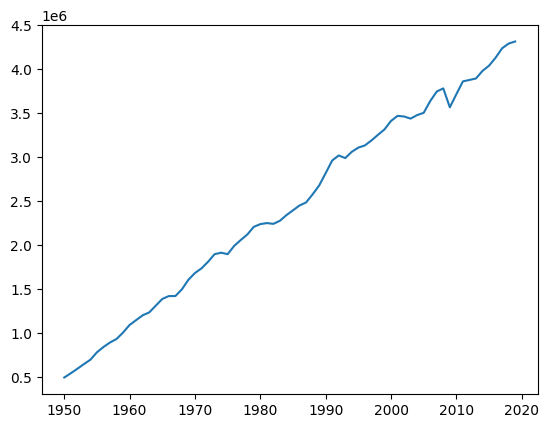

In [85]:
plt.plot(df_levels["year"], df_levels["rgdpna"])
plt.plot(df_levels["year"], reg.calc_add_quad(df_levels["rgdpna"]))